# Import

In [2]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi

import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax
import networkx as nx
m = bi(platform='cpu')
data_path = os.path.dirname(os.path.abspath("")) + "/BI/resources/data/"
G_undirected = nx.karate_club_graph()
G_directed = nx.DiGraph(G_undirected)  # Convert to directed graph

# Get the adjacency matrix for JAX
adj_matrix_np = nx.to_numpy_array(G_directed)
adj_matrix_jax = jnp.array(adj_matrix_np)

jax.local_device_count 16


# Test network metrics

In [7]:
print("Testing degree------------------------")
np.testing.assert_array_almost_equal(
    m.net.degree(adj_matrix_jax,  sym = True), 
    np.array(list(dict(nx.degree(G_undirected)).values()))
)
np.testing.assert_array_almost_equal(
    m.net.degree(adj_matrix_jax,  sym = False), 
    np.array(list(dict(nx.degree(G_undirected)).values()))*2
)

print("Testing indegree------------------------")
np.testing.assert_array_almost_equal(
    m.net.indegree(adj_matrix_jax,  normalize = True), 
    np.array(list(dict(nx.in_degree_centrality(G_directed)).values()))
)

print("Testing outdegree------------------------")
np.testing.assert_array_almost_equal(
    m.net.outdegree(adj_matrix_jax,  normalize = True), 
    np.array(list(dict(nx.out_degree_centrality(G_directed)).values()))
)

print("Testing strength------------------------")
np.testing.assert_array_almost_equal(
    m.net.strength(adj_matrix_jax,  sym = True), 
    np.array(list(dict(G_undirected.degree(weight="weight")).values()))
)
np.testing.assert_array_almost_equal(
    m.net.strength(adj_matrix_jax,  sym = False), 
    np.array(list(dict(G_undirected.degree(weight="weight")).values()))*2
)


print("Testing instrength------------------------")
np.testing.assert_array_almost_equal(
    m.net.instrength(adj_matrix_jax), 
    np.array(list(dict(G_directed.in_degree(weight="weight")).values()))
)

print("Testing outstrength------------------------")
np.testing.assert_array_almost_equal(
    m.net.outstrength(adj_matrix_jax), 
    np.array(list(dict(G_directed.out_degree(weight="weight")).values()))
)

print("Testing clustering coefficient------------------------")
np.testing.assert_array_almost_equal(
    m.net.cc(adj_matrix_jax), 
    np.array(list(dict(nx.clustering(G_directed)).values()))
)

print("Testing eigenvector centrality------------------------")
np.testing.assert_array_almost_equal(
    m.net.eigenvector(adj_matrix_jax), 
    np.array(list(dict(nx.eigenvector_centrality(G_undirected, max_iter=1000)).values()))
)


Testing degree------------------------
Testing indegree------------------------
Testing outdegree------------------------
Testing strength------------------------
Testing instrength------------------------
Testing outstrength------------------------
Testing clustering coefficient------------------------
Testing eigenvector centrality------------------------


AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 34 / 34 (100%)
Max absolute difference among violations: 0.07449154
Max relative difference among violations: 1.07037144
 ACTUAL: array([0.31235 , 0.30175 , 0.360588, 0.198566, 0.055674, 0.067428,
       0.066448, 0.178431, 0.246951, 0.050203, 0.045833, 0.043207,
       0.041869, 0.240486, 0.079538, 0.113115, 0.018519, 0.042718,...
 DESIRED: array([0.355483, 0.265954, 0.317189, 0.211174, 0.075966, 0.079481,
       0.079481, 0.170955, 0.227405, 0.102675, 0.075966, 0.052854,
       0.084252, 0.22647 , 0.101406, 0.101406, 0.023635, 0.092397,...

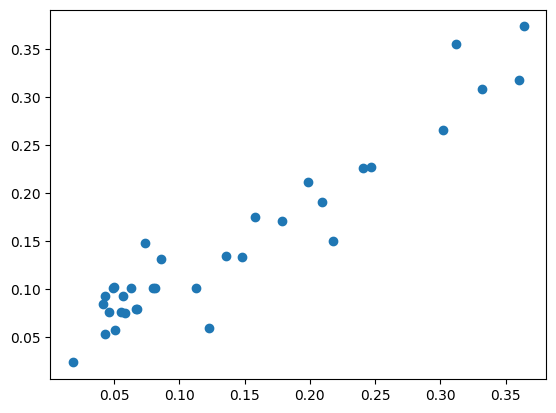

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(    m.net.eigenvector(adj_matrix_jax), 
    np.array(list(dict(nx.eigenvector_centrality(G_undirected, max_iter=1000)).values())))

# None jax betweenness

In [3]:
import jax
import jax.numpy as jnp
from jax import random
from typing import Optional, Tuple, Dict
import numpy as np
from collections import deque

def betweenness_centrality_jax(
    adjacency_matrix: jnp.ndarray,
    k: Optional[int] = None,
    normalized: bool = True,
    weight_matrix: Optional[jnp.ndarray] = None,
    endpoints: bool = False,
    seed: int = 42,
    directed: bool = False
) -> jnp.ndarray:
    """
    Compute the shortest-path betweenness centrality for nodes using JAX.
    
    Betweenness centrality of a node v is the sum of the fraction of all-pairs 
    shortest paths that pass through v.
    
    Parameters
    ----------
    adjacency_matrix : jnp.ndarray
        Square adjacency matrix of shape (n, n) where n is the number of nodes.
        adjacency_matrix[i, j] = 1 if there's an edge from i to j, 0 otherwise.
    
    k : int, optional (default=None)
        If k is not None, use k node samples to estimate betweenness.
        Higher values give better approximation.
    
    normalized : bool, optional (default=True)
        If True, normalize betweenness values by the appropriate factor.
    
    weight_matrix : jnp.ndarray, optional (default=None)
        Weight matrix of same shape as adjacency_matrix.
        If None, all edges have weight 1.
    
    endpoints : bool, optional (default=False)
        If True, include endpoints in shortest path counts.
    
    seed : int, optional (default=42)
        Random seed for sampling nodes when k is specified.
    
    directed : bool, optional (default=False)
        If True, treat the graph as directed. If False, treat as undirected.
    
    Returns
    -------
    betweenness : jnp.ndarray
        Array of betweenness centrality values for each node.
    """
    n_nodes = adjacency_matrix.shape[0]
    
    # Initialize betweenness centrality values
    betweenness = jnp.zeros(n_nodes)
    
    # Determine which nodes to use as sources
    if k is None or k >= n_nodes:
        source_nodes = jnp.arange(n_nodes)
    else:
        key = random.PRNGKey(seed)
        source_nodes = random.choice(key, n_nodes, (k,), replace=False)
    
    # Process each source node
    for s in source_nodes:
        if weight_matrix is None:
            # Unweighted shortest paths (BFS-style)
            S, P, sigma = _single_source_shortest_path_unweighted_jax(
                adjacency_matrix, s
            )
        else:
            # Weighted shortest paths (Dijkstra-style)
            S, P, sigma = _single_source_shortest_path_weighted_jax(
                adjacency_matrix, weight_matrix, s
            )
        
        # Accumulate betweenness centrality
        if endpoints:
            betweenness = _accumulate_endpoints_jax(betweenness, S, P, sigma, s)
        else:
            betweenness = _accumulate_basic_jax(betweenness, S, P, sigma, s)
    
    # Rescale the results
    betweenness = _rescale_jax(
        betweenness, n_nodes, normalized, k, endpoints, len(source_nodes), directed
    )
    
    return betweenness


def _single_source_shortest_path_unweighted_jax(
    adjacency_matrix: jnp.ndarray, 
    source: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Single-source shortest paths for unweighted graphs using BFS approach.
    
    Returns
    -------
    S : jnp.ndarray
        Nodes in order of non-increasing distance from source
    P : jnp.ndarray
        Predecessor matrix: P[v, u] = 1 if u is a predecessor of v
    sigma : jnp.ndarray
        Number of shortest paths from source to each node
    """
    n_nodes = adjacency_matrix.shape[0]
    
    # Initialize distances and predecessors
    dist = jnp.full(n_nodes, -1)
    dist = dist.at[source].set(0)
    sigma = jnp.zeros(n_nodes)
    sigma = sigma.at[source].set(1.0)
    
    # Store predecessors as lists (using a different approach)
    P = []
    for _ in range(n_nodes):
        P.append([])
    
    # BFS queue simulation
    current_layer = [source]
    current_dist = 0
    S = []  # Stack for nodes in order of discovery
    
    while current_layer:
        S.extend(current_layer)
        next_layer = []
        
        for v in current_layer:
            # Check all neighbors of v
            for w in range(n_nodes):
                if adjacency_matrix[v, w] > 0:  # There's an edge v -> w
                    # First time we see w
                    if dist[w] < 0:
                        dist = dist.at[w].set(current_dist + 1)
                        next_layer.append(w)
                        sigma = sigma.at[w].set(0.0)
                    
                    # If w is at the next level from v
                    if dist[w] == current_dist + 1:
                        sigma = sigma.at[w].add(sigma[v])
                        P[w].append(v)
        
        current_layer = next_layer
        current_dist += 1
    
    # Convert P to matrix format for compatibility
    P_matrix = jnp.zeros((n_nodes, n_nodes))
    for w in range(n_nodes):
        for v in P[w]:
            P_matrix = P_matrix.at[w, v].set(1.0)
    
    # S should be in reverse order for the algorithm
    S = jnp.array(S[::-1])
    
    return S, P_matrix, sigma


def _single_source_shortest_path_weighted_jax(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Single-source shortest paths for weighted graphs using Dijkstra's algorithm.
    """
    n_nodes = adjacency_matrix.shape[0]
    
    # Initialize distances and predecessors
    dist = jnp.full(n_nodes, jnp.inf)
    dist = dist.at[source].set(0.0)
    sigma = jnp.zeros(n_nodes)
    sigma = sigma.at[source].set(1.0)
    
    # Store predecessors as lists
    P = []
    for _ in range(n_nodes):
        P.append([])
    
    # Dijkstra's algorithm
    visited = jnp.zeros(n_nodes, dtype=bool)
    S = []  # Stack for nodes in order of completion
    
    for _ in range(n_nodes):
        # Find unvisited node with minimum distance
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        if jnp.all(jnp.isinf(unvisited_dist)):
            break
            
        u = int(jnp.argmin(unvisited_dist))
        
        if jnp.isinf(dist[u]):
            break
            
        visited = visited.at[u].set(True)
        S.append(u)
        
        # Update distances to neighbors
        for v in range(n_nodes):
            if adjacency_matrix[u, v] > 0 and not visited[v]:
                edge_weight = weight_matrix[u, v]
                new_dist = dist[u] + edge_weight
                
                # If we found a shorter path
                if dist[v] > new_dist:
                    dist = dist.at[v].set(new_dist)
                    sigma = sigma.at[v].set(sigma[u])
                    P[v] = [u]  # Reset predecessors
                
                # If we found an equally short path
                elif jnp.abs(dist[v] - new_dist) < 1e-10:
                    sigma = sigma.at[v].add(sigma[u])
                    P[v].append(u)
    
    # Convert P to matrix format
    P_matrix = jnp.zeros((n_nodes, n_nodes))
    for w in range(n_nodes):
        for v in P[w]:
            P_matrix = P_matrix.at[w, v].set(1.0)
    
    # S should be in reverse order
    S = jnp.array(S[::-1])
    
    return S, P_matrix, sigma


def _accumulate_basic_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    """
    Accumulate betweenness centrality (basic version without endpoints).
    """
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes)
    
    # Process nodes in reverse topological order (S is already reversed)
    for i in range(len(S)):
        w = int(S[i])
        if w == source:
            continue
            
        # Sum over predecessors
        predecessors = P[w] > 0
        for v in range(n_nodes):
            if predecessors[v] and sigma[w] > 0:
                coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                delta = delta.at[v].add(coeff)
        
        betweenness = betweenness.at[w].add(delta[w])
    
    return betweenness


def _accumulate_endpoints_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    """
    Accumulate betweenness centrality (with endpoints).
    """
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes)
    
    # Add contribution for source node
    betweenness = betweenness.at[source].add(len(S) - 1)
    
    # Process nodes in reverse topological order
    for i in reversed(range(len(S))):
        w = S[i]
        if w == source:
            continue
            
        # Add contribution for this endpoint
        betweenness = betweenness.at[w].add(delta[w] + 1)
        
        # Sum over predecessors
        predecessors = P[w] > 0
        for v in range(n_nodes):
            if predecessors[v]:
                coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                delta = delta.at[v].add(coeff)
    
    return betweenness


def _rescale_jax(
    betweenness: jnp.ndarray,
    n_nodes: int,
    normalized: bool,
    k: Optional[int],
    endpoints: bool,
    n_sampled: int,
    directed: bool = False
) -> jnp.ndarray:
    """
    Rescale betweenness centrality values.
    """
    if not normalized:
        return betweenness
    
    if n_nodes <= 2:
        return betweenness
    
    # Normalization factor based on NetworkX implementation
    if endpoints:
        # Include endpoints in normalization
        scale = 1.0 / ((n_nodes - 1) * (n_nodes - 2))
    else:
        # Standard normalization
        if directed:
            # For directed graphs: 1/((n-1)(n-2))
            scale = 1.0 / ((n_nodes - 1) * (n_nodes - 2))
        else:
            # For undirected graphs: 2/((n-1)(n-2))
            scale = 2.0 / ((n_nodes - 1) * (n_nodes - 2))
    
    # Adjust for sampling
    if k is not None and n_sampled < n_nodes:
        scale *= n_nodes / n_sampled
    
    return betweenness * scale


# Example usage and testing functions
def create_test_graph() -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Create a simple test graph for demonstration."""
    # Create a simple path graph: 0-1-2-3-4
    n = 5
    adj = jnp.zeros((n, n))
    for i in range(n-1):
        adj = adj.at[i, i+1].set(1.0)
        adj = adj.at[i+1, i].set(1.0)  # Make undirected
    
    # Create weight matrix (all weights = 1)
    weights = jnp.where(adj > 0, 1.0, 0.0)
    
    return adj, weights


def test_betweenness_centrality():
    """Test the betweenness centrality implementation."""
    adj, weights = create_test_graph()
    
    # Test unweighted (undirected graph)
    bc_unweighted = betweenness_centrality_jax(adj, normalized=True, directed=False)
    print("Unweighted betweenness centrality:")
    for i, val in enumerate(bc_unweighted):
        print(f"Node {i}: {val:.6f}")
    
    # Test weighted (undirected graph)
    bc_weighted = betweenness_centrality_jax(adj, weight_matrix=weights, normalized=True, directed=False)
    print("\nWeighted betweenness centrality:")
    for i, val in enumerate(bc_weighted):
        print(f"Node {i}: {val:.6f}")
    
    # Test with sampling
    bc_sampled = betweenness_centrality_jax(adj, k=3, normalized=True, seed=42, directed=False)
    print("\nSampled betweenness centrality (k=3):")
    for i, val in enumerate(bc_sampled):
        print(f"Node {i}: {val:.6f}")
    
    # Test with endpoints
    bc_endpoints = betweenness_centrality_jax(adj, endpoints=True, normalized=True, directed=False)
    print("\nBetweenness centrality with endpoints:")
    for i, val in enumerate(bc_endpoints):
        print(f"Node {i}: {val:.6f}")
    
    # Compare with expected NetworkX results for path graph 0-1-2-3-4
    expected = [0.0, 0.5, 0.6666666666666666, 0.5, 0.0]
    print("\nExpected NetworkX results:")
    for i, val in enumerate(expected):
        print(f"Node {i}: {val:.6f}")
    
    print("\nDifference from expected:")
    for i, (got, exp) in enumerate(zip(bc_unweighted, expected)):
        print(f"Node {i}: {abs(got - exp):.6f}")


# Additional debugging function
def debug_single_source(adj, source=0):
    """Debug single source shortest paths."""
    print(f"\nDebugging single source from node {source}:")
    S, P, sigma = _single_source_shortest_path_unweighted_jax(adj, source)
    
    print(f"S (traversal order): {S}")
    print(f"Sigma (path counts): {sigma}")
    print(f"Predecessors matrix P:")
    for i in range(len(P)):
        preds = [j for j in range(len(P)) if P[i, j] > 0]
        print(f"  Node {i}: predecessors = {preds}")
    
    return S, P, sigma

In [4]:
# Create a sample graph
G = nx.karate_club_graph()
N = G.number_of_nodes()

# Get the adjacency matrix for JAX
adj_matrix_np = nx.to_numpy_array(G)
adj_matrix_jax = jnp.array(adj_matrix_np)

bc_unweighted = betweenness_centrality_jax(adj_matrix_jax, normalized=True, directed=False)
bc_weighted = betweenness_centrality_jax(adj_matrix_jax, weight_matrix=adj_matrix_jax, normalized=True, directed=False)

In [6]:
bc_unweighted/2

Array([0.43763528, 0.05393669, 0.14365681, 0.01190927, 0.00063131,
       0.02998737, 0.02998737, 0.        , 0.05592683, 0.00084776,
       0.00063131, 0.        , 0.        , 0.0458634 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03247505,
       0.        , 0.        , 0.        , 0.01761364, 0.0022096 ,
       0.00384049, 0.        , 0.02233345, 0.00179473, 0.00292208,
       0.01441198, 0.13827561, 0.14524711, 0.30407498], dtype=float64)

In [37]:
nx.betweenness_centrality(G, normalized=True, weight=None)

{0: 0.43763528138528146,
 1: 0.053936688311688304,
 2: 0.14365680615680618,
 3: 0.011909271284271283,
 4: 0.0006313131313131313,
 5: 0.02998737373737374,
 6: 0.029987373737373736,
 7: 0.0,
 8: 0.05592682780182781,
 9: 0.0008477633477633478,
 10: 0.0006313131313131313,
 11: 0.0,
 12: 0.0,
 13: 0.04586339586339586,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.03247504810004811,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.017613636363636363,
 24: 0.0022095959595959595,
 25: 0.0038404882154882154,
 26: 0.0,
 27: 0.02233345358345358,
 28: 0.0017947330447330447,
 29: 0.0029220779220779218,
 30: 0.014411976911976909,
 31: 0.13827561327561325,
 32: 0.145247113997114,
 33: 0.30407497594997596}

In [45]:
bc_weighted/2

Array([0.47376894, 0.06401515, 0.06941288, 0.00252525, 0.00094697,
       0.02935606, 0.02935606, 0.        , 0.02481061, 0.01379419,
       0.00094697, 0.        , 0.        , 0.00227273, 0.        ,
       0.        , 0.        , 0.03049242, 0.00568182, 0.24065657,
       0.        , 0.        , 0.        , 0.00189394, 0.06407828,
       0.00094697, 0.        , 0.01231061, 0.01912879, 0.        ,
       0.00568182, 0.12563131, 0.07222222, 0.3967803 ], dtype=float64)

In [55]:
nx.betweenness_centrality(G, normalized=True, weight='weight')

{0: 0.4737689393939393,
 1: 0.06401515151515152,
 2: 0.0694128787878788,
 3: 0.0025252525252525255,
 4: 0.000946969696969697,
 5: 0.029356060606060608,
 6: 0.029356060606060608,
 7: 0.0,
 8: 0.02481060606060606,
 9: 0.01379419191919192,
 10: 0.000946969696969697,
 11: 0.0,
 12: 0.0,
 13: 0.0022727272727272726,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.030492424242424244,
 18: 0.005681818181818182,
 19: 0.24065656565656565,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.001893939393939394,
 24: 0.06407828282828282,
 25: 0.000946969696969697,
 26: 0.0,
 27: 0.01231060606060606,
 28: 0.019128787878787877,
 29: 0.0,
 30: 0.005681818181818182,
 31: 0.12563131313131315,
 32: 0.07222222222222223,
 33: 0.3967803030303029}

# test


In [68]:
G = nx.karate_club_graph()
adjacency_matrix = jnp.array(nx.to_numpy_array(G))
source=0

In [79]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop
from functools import partial
import timeit
from typing import Tuple

# Original function provided by the user
def _single_source_shortest_path_weighted_jax(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Single-source shortest paths for weighted graphs using Dijkstra's algorithm.
    """
    n_nodes = adjacency_matrix.shape[0]

    # Initialize distances and predecessors
    dist = jnp.full(n_nodes, jnp.inf)
    dist = dist.at[source].set(0.0)
    sigma = jnp.zeros(n_nodes)
    sigma = sigma.at[source].set(1.0)

    # Store predecessors as lists
    P = []
    for _ in range(n_nodes):
        P.append([])

    # Dijkstra's algorithm
    visited = jnp.zeros(n_nodes, dtype=bool)
    S = []  # Stack for nodes in order of completion

    for _ in range(n_nodes):
        # Find unvisited node with minimum distance
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        if jnp.all(jnp.isinf(unvisited_dist)):
            break

        u = int(jnp.argmin(unvisited_dist))

        if jnp.isinf(dist[u]):
            break

        visited = visited.at[u].set(True)
        S.append(u)

        # Update distances to neighbors
        for v in range(n_nodes):
            if adjacency_matrix[u, v] > 0 and not visited[v]:
                edge_weight = weight_matrix[u, v]
                new_dist = dist[u] + edge_weight

                # If we found a shorter path
                if dist[v] > new_dist:
                    dist = dist.at[v].set(new_dist)
                    sigma = sigma.at[v].set(sigma[u])
                    P[v] = [u]  # Reset predecessors

                # If we found an equally short path
                elif jnp.abs(dist[v] - new_dist) < 1e-10:
                    sigma = sigma.at[v].add(sigma[u])
                    P[v].append(u)

    # Convert P to matrix format
    P_matrix = jnp.zeros((n_nodes, n_nodes))
    for w in range(n_nodes):
        for v in P[w]:
            P_matrix = P_matrix.at[w, v].set(1.0)

    # S should be in reverse order
    S = jnp.array(S[::-1])

    return S, P_matrix, sigma


@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path_weighted(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int,
    n_nodes: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Optimized JAX implementation of Dijkstra's algorithm.
    """
    # 1. Initial state setup
    initial_dist = jnp.full(n_nodes, jnp.inf, dtype=jnp.float32).at[source].set(0.0)
    initial_sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    initial_P = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32)
    initial_visited = jnp.zeros(n_nodes, dtype=bool)
    initial_S = jnp.full(n_nodes, -1, dtype=jnp.int32)
    initial_s_idx = 0
    
    initial_state = (initial_dist, initial_sigma, initial_P, initial_visited, initial_S, initial_s_idx)

    def body_fun(_, state):
        dist, sigma, P_matrix, visited, S, s_idx = state

        # 2. Find the unvisited node with the minimum distance
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        u = jnp.argmin(unvisited_dist)
        min_dist_u = unvisited_dist[u]

        # 3. Handle the "early exit" condition
        do_update = min_dist_u < jnp.inf

        # 4. Update state for the selected node `u`
        S = S.at[s_idx].set(jnp.where(do_update, u, S[s_idx]))
        s_idx = jnp.where(do_update, s_idx + 1, s_idx)
        visited = visited.at[u].set(jnp.where(do_update, True, visited[u]))

        # 5. Vectorized update for all neighbors `v` of `u`
        new_dist_v = dist[u] + weight_matrix[u, :]
        is_neighbor = adjacency_matrix[u, :] > 0
        is_unvisited = ~visited

        shorter_path_found = do_update & is_neighbor & is_unvisited & (new_dist_v < dist)
        equal_path_found = do_update & is_neighbor & is_unvisited & (jnp.abs(new_dist_v - dist) < 1e-9)

        # Apply updates
        dist = jnp.where(shorter_path_found, new_dist_v, dist)
        sigma_after_reset = jnp.where(shorter_path_found, 0.0, sigma)
        sigma_to_add = jnp.where(shorter_path_found | equal_path_found, sigma[u], 0.0)
        sigma = sigma_after_reset + sigma_to_add

        P_matrix = jnp.where(shorter_path_found[:, jnp.newaxis], 0.0, P_matrix)
        predecessor_update_mask = shorter_path_found | equal_path_found
        new_col_u = jnp.where(predecessor_update_mask, 1.0, P_matrix[:, u])
        P_matrix = P_matrix.at[:, u].set(new_col_u)

        return dist, sigma, P_matrix, visited, S, s_idx

    # Run the fori_loop for n_nodes iterations
    _, final_sigma, final_P, _, final_S, final_s_idx = fori_loop(
        0, n_nodes, body_fun, initial_state
    )

    # 6. Finalize S: Reverse the valid part while maintaining a static shape.
    # We cannot slice the array to a dynamic size, so we must reverse within the full-size array.
    output_mask = jnp.arange(n_nodes) < final_s_idx
    gather_indices = jnp.maximum(0, final_s_idx - 1 - jnp.arange(n_nodes))
    reversed_S_padded = final_S[gather_indices]
    S_reversed = jnp.where(output_mask, reversed_S_padded, -1)

    return S_reversed, final_P, final_sigma


if __name__ == '__main__':
    # Define a sample weighted graph
    adjacency_matrix = jnp.array([
        [0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]
    ], dtype=jnp.float32)
    
    weight_matrix = jnp.array([
        [0, 2, 0, 4, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 2, 1],
        [0, 4, 0, 0, 0, 7],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 0]
    ], dtype=jnp.float32)

    source_node = 0
    n_nodes = adjacency_matrix.shape[0]

    # --- Test the original function ---
    print("--- Running Original Function ---")
    S_orig, P_orig, sigma_orig = _single_source_shortest_path_weighted_jax(
        adjacency_matrix, weight_matrix, source_node
    )

    # --- Test the optimized function ---
    print("--- Running Optimized Function ---")
    # First run will include compile time
    S_opt, P_opt, sigma_opt = _optimized_shortest_path_weighted(
        adjacency_matrix, weight_matrix, source_node, n_nodes=n_nodes
    )



--- Running Original Function ---
--- Running Optimized Function ---


In [96]:
m.astype(jnp.float32)

Array([[0., 4., 5., ..., 2., 0., 0.],
       [4., 0., 6., ..., 0., 0., 0.],
       [5., 6., 0., ..., 0., 2., 0.],
       ...,
       [2., 0., 0., ..., 0., 4., 4.],
       [0., 0., 2., ..., 4., 0., 5.],
       [0., 0., 0., ..., 4., 5., 0.]], dtype=float32)

In [87]:
m= jnp.array(nx.to_numpy_array(G))
m2=m.at[jnp.where(m>0)].set(1)
m.shape[0]

34

In [104]:
_optimized_shortest_path_weighted(
    m2.astype(jnp.float32), m.astype(jnp.float32), source_node, n_nodes=m.shape[0]
)


(Array([27, 23, 15, 25, 22, 16, 32, 30, 29, 26, 18, 14,  9,  2, 28, 24, 20,
        33, 13, 11,  6,  5,  4,  3,  1, 31, 21, 19, 17, 10,  8,  7, 12,  0],      dtype=int32),
 Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 2., 1., 1., 1.],      dtype=float32))

In [102]:
_optimized_shortest_path_weighted(
    m2.astype(jnp.float32), m.astype(jnp.float32), source_node, n_nodes=34
)

(Array([27, 23, 15, 25, 22, 16, 32, 30, 29, 26, 18, 14,  9,  2, 28, 24, 20,
        33, 13, 11,  6,  5,  4,  3,  1, 31, 21, 19, 17, 10,  8,  7, 12,  0],      dtype=int32),
 Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 2., 1., 1., 1.],      dtype=float32))

In [45]:
_optimized_shortest_path(
        adjacency_matrix, source_node, 5
    )

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[5]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [40]:
_single_source_shortest_path_unweighted_jax(
        adjacency_matrix, source_node
    )

(Array([4, 3, 2, 1, 0], dtype=int64),
 Array([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=float64),
 Array([1., 1., 1., 2., 1.], dtype=float64))

In [61]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop, dynamic_slice
from functools import partial
import timeit
from typing import Tuple

# Original function provided by the user
def _single_source_shortest_path_weighted_jax(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Single-source shortest paths for weighted graphs using Dijkstra's algorithm.
    """
    n_nodes = adjacency_matrix.shape[0]

    # Initialize distances and predecessors
    dist = jnp.full(n_nodes, jnp.inf)
    dist = dist.at[source].set(0.0)
    sigma = jnp.zeros(n_nodes)
    sigma = sigma.at[source].set(1.0)

    # Store predecessors as lists
    P = []
    for _ in range(n_nodes):
        P.append([])

    # Dijkstra's algorithm
    visited = jnp.zeros(n_nodes, dtype=bool)
    S = []  # Stack for nodes in order of completion

    for _ in range(n_nodes):
        # Find unvisited node with minimum distance
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        if jnp.all(jnp.isinf(unvisited_dist)):
            break

        u = int(jnp.argmin(unvisited_dist))

        if jnp.isinf(dist[u]):
            break

        visited = visited.at[u].set(True)
        S.append(u)

        # Update distances to neighbors
        for v in range(n_nodes):
            if adjacency_matrix[u, v] > 0 and not visited[v]:
                edge_weight = weight_matrix[u, v]
                new_dist = dist[u] + edge_weight

                # If we found a shorter path
                if dist[v] > new_dist:
                    dist = dist.at[v].set(new_dist)
                    sigma = sigma.at[v].set(sigma[u])
                    P[v] = [u]  # Reset predecessors

                # If we found an equally short path
                elif jnp.abs(dist[v] - new_dist) < 1e-10:
                    sigma = sigma.at[v].add(sigma[u])
                    P[v].append(u)

    # Convert P to matrix format
    P_matrix = jnp.zeros((n_nodes, n_nodes))
    for w in range(n_nodes):
        for v in P[w]:
            P_matrix = P_matrix.at[w, v].set(1.0)

    # S should be in reverse order
    S = jnp.array(S[::-1])

    return S, P_matrix, sigma


@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path_weighted(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int,
    n_nodes: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Optimized JAX implementation of Dijkstra's algorithm.
    """
    # 1. Initial state setup
    initial_dist = jnp.full(n_nodes, jnp.inf, dtype=jnp.float32).at[source].set(0.0)
    initial_sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    initial_P = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32)
    initial_visited = jnp.zeros(n_nodes, dtype=bool)
    initial_S = jnp.full(n_nodes, -1, dtype=jnp.int32)
    initial_s_idx = 0
    
    initial_state = (initial_dist, initial_sigma, initial_P, initial_visited, initial_S, initial_s_idx)

    def body_fun(_, state):
        dist, sigma, P_matrix, visited, S, s_idx = state

        # 2. Find the unvisited node with the minimum distance
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        u = jnp.argmin(unvisited_dist)
        min_dist_u = unvisited_dist[u]

        # 3. Handle the "early exit" condition
        do_update = min_dist_u < jnp.inf

        # 4. Update state for the selected node `u`
        S = S.at[s_idx].set(jnp.where(do_update, u, S[s_idx]))
        s_idx = jnp.where(do_update, s_idx + 1, s_idx)
        visited = visited.at[u].set(jnp.where(do_update, True, visited[u]))

        # 5. Vectorized update for all neighbors `v` of `u`
        new_dist_v = dist[u] + weight_matrix[u, :]

        is_neighbor = adjacency_matrix[u, :] > 0
        is_unvisited = ~visited # BUG FIX: Check neighbors, not current node.

        shorter_path_found = do_update & is_neighbor & is_unvisited & (new_dist_v < dist)
        equal_path_found = do_update & is_neighbor & is_unvisited & (jnp.abs(new_dist_v - dist) < 1e-9)

        # Apply updates
        dist = jnp.where(shorter_path_found, new_dist_v, dist)
        
        sigma_after_reset = jnp.where(shorter_path_found, 0.0, sigma)
        sigma_to_add = jnp.where(shorter_path_found | equal_path_found, sigma[u], 0.0)
        sigma = sigma_after_reset + sigma_to_add

        # JIT-Friendly Predecessor Matrix Update
        # 1. If shorter path to `v` found, clear all of `v`'s predecessors (the entire row).
        P_matrix = jnp.where(shorter_path_found[:, jnp.newaxis], 0.0, P_matrix)
        
        # 2. Construct the new column `u` for the P_matrix and update it.
        predecessor_update_mask = shorter_path_found | equal_path_found
        # The new values for column `u` are 1.0 where the mask is true, and the old value otherwise.
        new_col_u = jnp.where(predecessor_update_mask, 1.0, P_matrix[:, u])
        P_matrix = P_matrix.at[:, u].set(new_col_u)

        return dist, sigma, P_matrix, visited, S, s_idx

    # Run the fori_loop for n_nodes iterations
    _, final_sigma, final_P, _, final_S, final_s_idx = fori_loop(
        0, n_nodes, body_fun, initial_state
    )

    # 6. Finalize the results using dynamic_slice
    valid_S = dynamic_slice(final_S, [0], [final_s_idx])
    S_reversed = jnp.flip(valid_S)

    return S_reversed, final_P, final_sigma


if __name__ == '__main__':
    # Define a sample weighted graph
    adjacency_matrix = jnp.array([
        [0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]
    ], dtype=jnp.float32)
    
    weight_matrix = jnp.array([
        [0, 2, 0, 4, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 2, 1],
        [0, 4, 0, 0, 0, 7],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 0]
    ], dtype=jnp.float32)

    source_node = 0
    n_nodes = adjacency_matrix.shape[0]

    # --- Test the original function ---
    print("--- Running Original Function ---")
    S_orig, P_orig, sigma_orig = _single_source_shortest_path_weighted_jax(
        adjacency_matrix, weight_matrix, source_node
    )
    print("S (Nodes in order of non-increasing distance):\n", S_orig)
    print("\nP (Predecessor matrix):\n", P_orig)
    print("\nsigma (Number of shortest paths):\n", sigma_orig)
    print("-" * 30, "\n")
    
    # --- Test the optimized function ---
    print("--- Running Optimized Function ---")
    # First run will include compile time
    S_opt, P_opt, sigma_opt = _optimized_shortest_path_weighted(
        adjacency_matrix, weight_matrix, source_node, n_nodes=n_nodes
    )
    print("S (Nodes in order of non-increasing distance):\n", S_opt)
    print("\nP (Predecessor matrix):\n", P_opt)
    print("\nsigma (Number of shortest paths):\n", sigma_opt)
    print("-" * 30, "\n")
    
    # --- Performance Comparison ---
    print("--- Performance Comparison ---")
    
    # Time the original function
    original_time = timeit.timeit(
        lambda: _single_source_shortest_path_weighted_jax(adjacency_matrix, weight_matrix, source_node),
        number=100
    )
    print(f"Original function average time: {original_time / 100:.6f} seconds")

    # JIT the function for benchmarking
    jitted_func = partial(_optimized_shortest_path_weighted, n_nodes=n_nodes)
    
    # Run once to ensure it's compiled before timing
    jitted_func(adjacency_matrix, weight_matrix, source_node)[0].block_until_ready()
    
    optimized_time = timeit.timeit(
        lambda: jitted_func(adjacency_matrix, weight_matrix, source_node)[0].block_until_ready(),
        number=100
    )
    print(f"Optimized function average time: {optimized_time / 100:.6f} seconds")

--- Running Original Function ---
S (Nodes in order of non-increasing distance):
 [4 5 3 2 1 0]

P (Predecessor matrix):
 [[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]

sigma (Number of shortest paths):
 [1. 1. 1. 1. 1. 1.]
------------------------------ 

--- Running Optimized Function ---


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<~int64[]>with<DynamicJaxprTrace>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function _optimized_shortest_path_weighted at /tmp/ipykernel_39521/2378058160.py:78 for jit. This concrete value was not available in Python because it depends on the values of the arguments adjacency_matrix, weight_matrix, and source.

# step by step

## shortest path weighed

In [10]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop
from functools import partial
import timeit
# Create a sample graph
G = nx.karate_club_graph()
N = G.number_of_nodes()

# Get the adjacency matrix for JAX
adj_matrix_np = nx.to_numpy_array(G)
m = jnp.array(adj_matrix_np)
m2= m.at[jnp.where(m > 0)].set(1)
source=0
n_nodes=m2.shape[0]

In [11]:
@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path_weighted(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int,
    n_nodes: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Optimized JAX implementation of Dijkstra's algorithm.
    """
    # 1. Initial state setup
    initial_dist = jnp.full(n_nodes, jnp.inf, dtype=jnp.float32).at[source].set(0.0)
    initial_sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    initial_P = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32)
    initial_visited = jnp.zeros(n_nodes, dtype=bool)
    initial_S = jnp.full(n_nodes, -1, dtype=jnp.int32)
    initial_s_idx = 0
    
    initial_state = (initial_dist, initial_sigma, initial_P, initial_visited, initial_S, initial_s_idx)

    def body_fun(_, state):
        dist, sigma, P_matrix, visited, S, s_idx = state

        # 2. Find the unvisited node with the minimum distance
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        u = jnp.argmin(unvisited_dist)
        min_dist_u = unvisited_dist[u]

        # 3. Handle the "early exit" condition
        do_update = min_dist_u < jnp.inf

        # 4. Update state for the selected node `u`
        S = S.at[s_idx].set(jnp.where(do_update, u, S[s_idx]))
        s_idx = jnp.where(do_update, s_idx + 1, s_idx)
        visited = visited.at[u].set(jnp.where(do_update, True, visited[u]))

        # 5. Vectorized update for all neighbors `v` of `u`
        new_dist_v = dist[u] + weight_matrix[u, :]
        is_neighbor = adjacency_matrix[u, :] > 0
        is_unvisited = ~visited

        shorter_path_found = do_update & is_neighbor & is_unvisited & (new_dist_v < dist)
        equal_path_found = do_update & is_neighbor & is_unvisited & (jnp.abs(new_dist_v - dist) < 1e-9)

        # Apply updates
        dist = jnp.where(shorter_path_found, new_dist_v, dist)
        sigma_after_reset = jnp.where(shorter_path_found, 0.0, sigma)
        sigma_to_add = jnp.where(shorter_path_found | equal_path_found, sigma[u], 0.0)
        sigma = sigma_after_reset + sigma_to_add

        P_matrix = jnp.where(shorter_path_found[:, jnp.newaxis], 0.0, P_matrix)
        predecessor_update_mask = shorter_path_found | equal_path_found
        new_col_u = jnp.where(predecessor_update_mask, 1.0, P_matrix[:, u])
        P_matrix = P_matrix.at[:, u].set(new_col_u)

        return dist, sigma, P_matrix, visited, S, s_idx

    # Run the fori_loop for n_nodes iterations
    _, final_sigma, final_P, _, final_S, final_s_idx = fori_loop(
        0, n_nodes, body_fun, initial_state
    )

    # 6. Finalize S: Reverse the valid part while maintaining a static shape.
    # We cannot slice the array to a dynamic size, so we must reverse within the full-size array.
    output_mask = jnp.arange(n_nodes) < final_s_idx
    gather_indices = jnp.maximum(0, final_s_idx - 1 - jnp.arange(n_nodes))
    reversed_S_padded = final_S[gather_indices]
    S_reversed = jnp.where(output_mask, reversed_S_padded, -1)

    return S_reversed, final_P, final_sigma

In [12]:
S, P, sigma = _optimized_shortest_path_weighted(m2.astype(jnp.float32), m.astype(jnp.float32), source, n_nodes)

/home/sosa/work/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


## shortest path unweighed

In [13]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop
from functools import partial
import timeit
import numpy as np

# Original function provided by the user
def _single_source_shortest_path_unweighted_jax(
    adjacency_matrix: jnp.ndarray,
    source: int
):
    """
    Single-source shortest paths for unweighted graphs using BFS approach.
    """
    n_nodes = adjacency_matrix.shape[0]
    dist = jnp.full(n_nodes, -1).at[source].set(0)
    sigma = jnp.zeros(n_nodes).at[source].set(1.0)
    P = [[] for _ in range(n_nodes)]
    current_layer = [source]
    current_dist = 0
    S = []
    while current_layer:
        S.extend(current_layer)
        next_layer = []
        for v in current_layer:
            for w in range(n_nodes):
                if adjacency_matrix[v, w] > 0:
                    if dist[w] < 0:
                        dist = dist.at[w].set(current_dist + 1)
                        next_layer.append(w)
                    if dist[w] == current_dist + 1:
                        sigma = sigma.at[w].add(sigma[v])
                        P[w].append(v)
        current_layer = next_layer
        current_dist += 1
    P_matrix = jnp.zeros((n_nodes, n_nodes))
    for w in range(n_nodes):
        for v in P[w]:
            P_matrix = P_matrix.at[w, v].set(1.0)
    S = jnp.array(S[::-1])
    return S, P_matrix, sigma

@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path(adjacency_matrix, source, n_nodes):
    """
    Optimized single-source shortest paths for unweighted graphs using BFS.
    """
    # Initial state
    dist = jnp.full(n_nodes, -1, dtype=jnp.int32).at[source].set(0)
    sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    P_matrix = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32)

    # Initial layer is represented by a boolean mask where dist == 0
    layer_mask = (dist == 0)

    def body_fun(i, state):
        dist, sigma, P_matrix, layer_mask = state

        # Get neighbors of all nodes in the current layer
        neighbors_matrix = jnp.where(layer_mask[:, None], adjacency_matrix, 0)

        # Potential next layer nodes are any neighbors of the current layer
        potential_next_layer = (neighbors_matrix.sum(axis=0) > 0)

        # New nodes are those that haven't been visited yet (-1 distance)
        newly_discovered_mask = potential_next_layer & (dist == -1)
        dist = jnp.where(newly_discovered_mask, i + 1, dist)

        # Nodes in the next layer are those whose distance is now i + 1
        is_in_next_layer_mask = (dist == i + 1)

        # For each node `w` in the next layer, sum the sigma of its predecessors `v`
        # from the current layer (`layer_mask`).
        predecessor_mask = (adjacency_matrix.T > 0) & layer_mask[None, :]
        predecessor_sigmas = jnp.where(predecessor_mask, sigma[None, :], 0)
        sigma_contribution = predecessor_sigmas.sum(axis=1)
        
        # Add contributions to the sigmas of nodes in the next layer
        sigma = jnp.where(is_in_next_layer_mask, sigma + sigma_contribution, sigma)

        # Update predecessor matrix: P[w, v] = 1 if v is a predecessor of w.
        P_update = jnp.where(
            is_in_next_layer_mask[None, :] & layer_mask[:, None] & (adjacency_matrix > 0),
            1.0, 0
        )
        P_matrix = P_matrix + P_update.T

        # The next layer for the next iteration are the nodes we just discovered.
        return dist, sigma, P_matrix, is_in_next_layer_mask

    # The loop runs at most n_nodes times
    dist, sigma, P_matrix, _ = fori_loop(
        0, n_nodes, body_fun, (dist, sigma, P_matrix, layer_mask)
    )

    # After the loop, derive S from the final distances.
    # --- THIS IS THE FIXED LINE ---
    S = jnp.flip(jnp.argsort(dist, stable=True))

    return S, P_matrix, sigma, dist


if __name__ == '__main__':
    # Define a sample adjacency matrix for a graph
    adjacency_matrix = jnp.array([
        [0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]
    ], dtype=jnp.float32)

    source_node = 0
    n_nodes = adjacency_matrix.shape[0]

    # --- Test the original function ---
    print("--- Running Original Function ---")
    S_orig, P_orig, sigma_orig = _single_source_shortest_path_unweighted_jax(
        adjacency_matrix, source_node
    )
    print("S (Nodes in order of non-increasing distance):\n", S_orig)
    print("\nP (Predecessor matrix):\n", P_orig)
    print("\nsigma (Number of shortest paths):\n", sigma_orig)
    print("-" * 30, "\n")


    # --- Test the optimized function ---
    print("--- Running Optimized Function ---")
    partial_optimized_func = partial(_optimized_shortest_path, n_nodes=n_nodes)

    # First run will include compile time
    S_opt_padded, P_opt, sigma_opt, dist_opt = partial_optimized_func(adjacency_matrix, source_node)

    # The optimized function returns S padded with unvisited nodes. Filter them out for comparison.
    S_opt = S_opt_padded[dist_opt[S_opt_padded] != -1]

    print("S (Nodes in order of non-increasing distance):\n", S_opt)
    print("\nP (Predecessor matrix):\n", P_opt)
    print("\nsigma (Number of shortest paths):\n", sigma_opt)
    print("-" * 30, "\n")



--- Running Original Function ---
S (Nodes in order of non-increasing distance):
 [4 3 2 1 0]

P (Predecessor matrix):
 [[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]

sigma (Number of shortest paths):
 [1. 1. 1. 2. 1.]
------------------------------ 

--- Running Optimized Function ---
S (Nodes in order of non-increasing distance):
 [4 3 2 1 0]

P (Predecessor matrix):
 [[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]

sigma (Number of shortest paths):
 [1. 1. 1. 2. 1.]
------------------------------ 



## accumulate

In [23]:


# Original function provided by the user
def _accumulate_basic_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    """
    Accumulate betweenness centrality (basic version without endpoints).
    """
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes)

    # Process nodes in reverse topological order (S is already reversed)
    for i in range(len(S)):
        w = int(S[i])
        if w == source:
            continue

        # Sum over predecessors
        predecessors = P[w,:] > 0
        for v in range(n_nodes):
            if predecessors[v] and sigma[w] > 0:
                coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                delta = delta.at[v].add(coeff)

        betweenness = betweenness.at[w].add(delta[w])

    return betweenness


@partial(jit, static_argnames=['n_nodes'])
def _optimized_accumulate_basic(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int,
    n_nodes: int
) -> jnp.ndarray:
    """
    Optimized JAX implementation of betweenness centrality accumulation.
    """
    # 1. Initial state setup for the loop
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    initial_state = (betweenness, initial_delta)

    def body_fun(i, state):
        betweenness, delta = state
        
        # 2. Get the current node `w` from the stack S
        w = S[i]

        # 3. Vectorized update of delta for all predecessors `v` of `w`
        # P[w, :] gives a row where P[w, v] == 1 if v is a predecessor of w
        predecessors_mask = P[w, :] > 0
        
        # Calculate the coefficient safely, avoiding division by zero
        # If sigma[w] is 0, the coefficient will be 0.
        coeff = (sigma / sigma[w]) * (1.0 + delta[w])
        
        # Calculate the update for delta: only add coeff for predecessors of w
        delta_update = jnp.where(predecessors_mask, coeff, 0.0)
        delta_new = delta + delta_update
        
        # 4. Update the betweenness for node `w`
        # This is done only for the current node `w`, not for the source.
        # Note: The original code adds the *old* delta[w] value.
        betweenness_update = jnp.where(w == source, 0.0, delta[w])
        betweenness_new = betweenness.at[w].add(betweenness_update)

        return (betweenness_new, delta_new)

    # 5. Run the fori_loop over all nodes in S
    # The loop iterates through S, which is in reverse topological order.
    final_betweenness, _ = fori_loop(0, n_nodes, body_fun, initial_state)

    return final_betweenness
n_nodes=m.shape[0]

initial_betweenness=jnp.zeros(n_nodes)
initial_betweenness

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64)

In [24]:
# First run includes compile time.
_accumulate_basic_jax(
    initial_betweenness.copy(), S, P, sigma, source_node
)

Array([ 0.        ,  0.5       ,  0.33333334,  0.        ,  0.        ,
        0.5       ,  0.5       ,  0.        ,  1.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.5       ,  0.        , 10.33333334,
        0.        ,  0.        ,  0.        ,  0.        ,  1.33333334,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  3.33333334,  0.        ,  9.33333334], dtype=float64)

In [25]:

_optimized_accumulate_basic(
    initial_betweenness.copy(), S, P, sigma, source_node, n_nodes=n_nodes
)

Array([ 0.        ,  0.5       ,  0.33333334,  0.        ,  0.        ,
        0.5       ,  0.5       ,  0.        ,  1.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.5       ,  0.        , 10.33333397,
        0.        ,  0.        ,  0.        ,  0.        ,  1.33333337,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  3.33333349,  0.        ,  9.33333397], dtype=float64)

## accumulate_endpoints

In [26]:

# Original function provided by the user
def _accumulate_endpoints_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    """
    Accumulate betweenness centrality (with endpoints).
    """
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes)

    # Add contribution for source node
    # Note: len(S) might not be n_nodes if the graph is disconnected
    betweenness = betweenness.at[source].add(len(S) - 1)

    # Process nodes in reverse topological order
    for i in reversed(range(len(S))):
        w = S[i]
        if w == source:
            continue

        # Add contribution for this endpoint
        betweenness = betweenness.at[w].add(delta[w] + 1)

        # Sum over predecessors
        predecessors = P[w,:] > 0
        for v in range(n_nodes):
            if predecessors[v]:
                # Avoid division by zero
                if sigma[w] > 0:
                    coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta = delta.at[v].add(coeff)

    return betweenness


@partial(jit, static_argnames=['n_nodes', 's_len'])
def _optimized_accumulate_endpoints(
    betweenness: jnp.ndarray,
    S: jnp.ndarray, # IMPORTANT: This S must be pre-reversed
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int,
    n_nodes: int,
    s_len: int
) -> jnp.ndarray:
    """
    Optimized JAX implementation of betweenness centrality accumulation with endpoints.
    """
    # 1. Initial contribution for the source node
    betweenness = betweenness.at[source].add(s_len - 1)
    
    # 2. Initial state for the loop
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    initial_state = (betweenness, initial_delta)

    def body_fun(i, state):
        betweenness, delta = state
        
        # 3. Get node `w` from the pre-reversed stack S
        # FIX: Access directly, as S is already in the correct processing order.
        w = S[i]
        
        # 4. Update betweenness for node `w` (if it's not the source)
        betweenness_update_val = delta[w] + 1
        betweenness = betweenness.at[w].add(
            jnp.where(w != source, betweenness_update_val, 0.0)
        )

        # 5. Vectorized update of delta for all predecessors `v` of `w`
        predecessors_mask = P[w, :] > 0
        
        # Calculate coefficient safely, avoiding division by zero
        safe_sigma_w = jnp.where(sigma[w] == 0, 1.0, sigma[w])
        coeff = (sigma / safe_sigma_w) * (1.0 + delta[w])
        
        # Only apply coefficient for actual predecessors and where sigma[w] > 0
        is_valid_update = predecessors_mask & (sigma[w] > 0)
        delta_update = jnp.where(is_valid_update, coeff, 0.0)
        delta = delta + delta_update

        return (betweenness, delta)

    # 6. Run the fori_loop over the length of S
    final_betweenness, _ = fori_loop(0, s_len, body_fun, initial_state)

    return final_betweenness



In [27]:
_accumulate_endpoints_jax(
        initial_betweenness.copy(), S, P, sigma, source_node
    )

Array([33.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float64)

In [28]:
_optimized_accumulate_endpoints(
        initial_betweenness.copy(), S, P, sigma, source_node, n_nodes, n_nodes
    )

Array([33.        ,  1.5       ,  1.33333337,  1.        ,  1.        ,
        1.5       ,  1.5       ,  1.        ,  2.5       ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  2.5       ,  1.        , 11.33333397,
        1.        ,  1.        ,  1.        ,  1.        ,  2.33333349,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  4.33333349,  1.        , 10.33333397], dtype=float64)

In [29]:


# (Include the previously optimized _optimized_shortest_path_weighted function here)
@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path_weighted(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int,
    n_nodes: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    initial_dist = jnp.full(n_nodes, jnp.inf, dtype=jnp.float32).at[source].set(0.0)
    initial_sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    initial_P = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32)
    initial_visited = jnp.zeros(n_nodes, dtype=bool)
    initial_S = jnp.full(n_nodes, -1, dtype=jnp.int32)
    initial_s_idx = 0
    initial_state = (initial_dist, initial_sigma, initial_P, initial_visited, initial_S, initial_s_idx)
    def body_fun(_, state):
        dist, sigma, P_matrix, visited, S, s_idx = state
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        u = jnp.argmin(unvisited_dist)
        min_dist_u = unvisited_dist[u]
        do_update = min_dist_u < jnp.inf
        S = S.at[s_idx].set(jnp.where(do_update, u, S[s_idx]))
        s_idx = jnp.where(do_update, s_idx + 1, s_idx)
        visited = visited.at[u].set(jnp.where(do_update, True, visited[u]))
        new_dist_v = dist[u] + weight_matrix[u, :]
        is_neighbor = adjacency_matrix[u, :] > 0
        is_unvisited = ~visited
        shorter_path_found = do_update & is_neighbor & is_unvisited & (new_dist_v < dist)
        equal_path_found = do_update & is_neighbor & is_unvisited & (jnp.abs(new_dist_v - dist) < 1e-9)
        dist = jnp.where(shorter_path_found, new_dist_v, dist)
        sigma_after_reset = jnp.where(shorter_path_found, 0.0, sigma)
        sigma_to_add = jnp.where(shorter_path_found | equal_path_found, sigma[u], 0.0)
        sigma = sigma_after_reset + sigma_to_add
        P_matrix = jnp.where(shorter_path_found[:, jnp.newaxis], 0.0, P_matrix)
        predecessor_update_mask = shorter_path_found | equal_path_found
        new_col_u = jnp.where(predecessor_update_mask, 1.0, P_matrix[:, u])
        P_matrix = P_matrix.at[:, u].set(new_col_u)
        return dist, sigma, P_matrix, visited, S, s_idx
    _, final_sigma, final_P, _, final_S, final_s_idx = fori_loop(0, n_nodes, body_fun, initial_state)
    output_mask = jnp.arange(n_nodes) < final_s_idx
    gather_indices = jnp.maximum(0, final_s_idx - 1 - jnp.arange(n_nodes))
    reversed_S_padded = final_S.at[gather_indices].get(mode='clip')
    S_reversed = jnp.where(output_mask, reversed_S_padded, -1)
    return S_reversed, final_P, final_sigma

# Original (buggy) function for comparison
def _accumulate_endpoints_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    s_len = (S != -1).sum()
    betweenness = betweenness.at[source].add(s_len - 1)
    for i in reversed(range(s_len)):
        w = S[i]
        if w == source:
            continue
        betweenness = betweenness.at[w].add(delta[w] + 1)
        predecessors = P[w,:] > 0
        for v in range(n_nodes):
            if predecessors[v]:
                if sigma[w] > 0:
                    coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta = delta.at[v].add(coeff)
    return betweenness

# Final Corrected and Optimized Function
@partial(jit, static_argnames=['n_nodes', 's_len'])
def _optimized_accumulate_endpoints(
    betweenness: jnp.ndarray,
    S: jnp.ndarray, # IMPORTANT: This S must be pre-reversed
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int,
    n_nodes: int,
    s_len: int
) -> jnp.ndarray:
    """
    Optimized JAX implementation of betweenness centrality accumulation with endpoints.
    """
    betweenness = betweenness.at[source].add(s_len - 1)
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    initial_state = (betweenness, initial_delta)

    def body_fun(i, state):
        betweenness, delta = state
        w = S[i]
        betweenness_update_val = delta[w] + 1
        betweenness = betweenness.at[w].add(
            jnp.where(w != source, betweenness_update_val, 0.0)
        )
        predecessors_mask = P[w, :] > 0
        safe_sigma_w = jnp.where(sigma[w] == 0, 1.0, sigma[w])
        coeff = (sigma / safe_sigma_w) * (1.0 + delta[w])
        is_valid_update = predecessors_mask & (sigma[w] > 0)
        delta_update = jnp.where(is_valid_update, coeff, 0.0)
        delta = delta + delta_update
        return (betweenness, delta)

    final_betweenness, _ = fori_loop(0, s_len, body_fun, initial_state)
    return final_betweenness


# Rescale

In [50]:
from typing import Optional
import jax.numpy as jnp
from jax import jit, lax

@jit
def _rescale_jax(
    betweenness: jnp.ndarray,
    n_nodes: int,
    normalized: bool,
    k: Optional[int],
    endpoints: bool,
    n_sampled: int,
    directed: bool = False
) -> jnp.ndarray:
    """
    Rescale betweenness centrality values in a JAX-compatible way.
    """

    def scale_fn(_):
        # If n_nodes <= 2, return unscaled
        def small_graph(_):
            return betweenness

        def normal_graph(_):
            # Compute base scale factor
            def endpoints_scale(_):
                return 1.0 / ((n_nodes - 1) * (n_nodes - 2))
            
            def directed_or_undirected(_):
                return lax.cond(directed,
                                lambda _: 1.0 / ((n_nodes - 1) * (n_nodes - 2)),
                                lambda _: 2.0 / ((n_nodes - 1) * (n_nodes - 2)),
                                operand=None)

            scale = lax.cond(endpoints, endpoints_scale, directed_or_undirected, operand=None)

            # Adjust for sampling if applicable
            scale = lax.cond((k is not None) & (n_sampled < n_nodes),
                             lambda s: s * n_nodes / n_sampled,
                             lambda s: s,
                             operand=scale)
            
            return betweenness * scale

        return lax.cond(n_nodes <= 2, small_graph, normal_graph, operand=None)

    # If normalized is False, return betweenness as-is
    return lax.cond(normalized, scale_fn, lambda _: betweenness, operand=None)


# Final

In [33]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop
from functools import partial
import timeit
# Create a sample graph
G = nx.karate_club_graph()
N = G.number_of_nodes()

# Get the adjacency matrix for JAX
adj_matrix_np = nx.to_numpy_array(G)
m = jnp.array(adj_matrix_np)
m2= m.at[jnp.where(m > 0)].set(1)
source=0
n_nodes=m2.shape[0]

In [35]:
# Import necessary libraries and functions
from typing import Optional, Tuple
import jax.numpy as jnp  # JAX's version of NumPy
from jax import jit, lax, random  # Core JAX functions: jit for compilation, lax for control flow
from functools import partial # Used to pre-fill function arguments

# This decorator @partial(jit, static_argnames=['n_nodes']) compiles the function for speed.
# 'n_nodes' is marked as a static argument, meaning the function will be re-compiled
# if n_nodes changes. This is necessary because the size of arrays depends on it.
@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path_weighted(
    adjacency_matrix: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    source: int,
    n_nodes: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Optimized JAX implementation of Dijkstra's algorithm to find the shortest paths
    in a weighted graph from a single source node. It also calculates the number of
    shortest paths (sigma) and the predecessors of each node (P).
    """
    # 1. Initial state setup
    # `dist`: distance from the source to each node, initialized to infinity except for the source (0).
    initial_dist = jnp.full(n_nodes, jnp.inf, dtype=jnp.float32).at[source].set(0.0)
    # `sigma`: number of shortest paths from the source to each node. Source has 1 path to itself.
    initial_sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    # `P`: predecessor matrix. P[i, j] = 1 if j is a predecessor of i in a shortest path.
    initial_P = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32)
    # `visited`: boolean array to track visited nodes.
    initial_visited = jnp.zeros(n_nodes, dtype=bool)
    # `S`: A stack to store nodes in the order they are visited.
    initial_S = jnp.full(n_nodes, -1, dtype=jnp.int32)
    initial_s_idx = 0 # Index for the stack S.

    # Package all initial variables into a single state tuple for the loop.
    initial_state = (initial_dist, initial_sigma, initial_P, initial_visited, initial_S, initial_s_idx)

    # This is the main loop body, which will run n_nodes times.
    def body_fun(_, state):
        dist, sigma, P_matrix, visited, S, s_idx = state

        # 2. Find the unvisited node `u` with the smallest distance.
        # Temporarily set distances of visited nodes to infinity to ignore them.
        unvisited_dist = jnp.where(visited, jnp.inf, dist)
        u = jnp.argmin(unvisited_dist)
        min_dist_u = unvisited_dist[u]

        # 3. Handle the "early exit" condition for disconnected graphs.
        # If the smallest distance is infinity, all reachable nodes have been visited.
        do_update = min_dist_u < jnp.inf

        # 4. Update state for the selected node `u`.
        # Add `u` to the stack S and mark it as visited, but only if do_update is true.
        S = S.at[s_idx].set(jnp.where(do_update, u, S[s_idx]))
        s_idx = jnp.where(do_update, s_idx + 1, s_idx)
        visited = visited.at[u].set(jnp.where(do_update, True, visited[u]))

        # 5. Vectorized update for all neighbors `v` of `u`.
        # This is the core of Dijkstra's: relax all edges from `u`.
        new_dist_v = dist[u] + weight_matrix[u, :] # Calculate potential new distances.
        is_neighbor = adjacency_matrix[u, :] > 0 # Mask for neighbors.
        is_unvisited = ~visited # Mask for unvisited nodes.

        # A shorter path to a neighbor `v` is found.
        shorter_path_found = do_update & is_neighbor & is_unvisited & (new_dist_v < dist)
        # A path of the same length to a neighbor `v` is found.
        equal_path_found = do_update & is_neighbor & is_unvisited & (jnp.abs(new_dist_v - dist) < 1e-9)

        # Apply updates using the boolean masks calculated above.
        dist = jnp.where(shorter_path_found, new_dist_v, dist) # Update distances.
        # If a shorter path is found, reset sigma for `v`.
        sigma_after_reset = jnp.where(shorter_path_found, 0.0, sigma)
        # If a shorter or equal path is found, add `u`'s sigma to `v`'s sigma.
        sigma_to_add = jnp.where(shorter_path_found | equal_path_found, sigma[u], 0.0)
        sigma = sigma_after_reset + sigma_to_add

        # Update the predecessor matrix P.
        # If a shorter path is found, reset `v`'s predecessors.
        P_matrix = jnp.where(shorter_path_found[:, jnp.newaxis], 0.0, P_matrix)
        # Add `u` as a predecessor for `v` if a shorter or equal path is found.
        predecessor_update_mask = shorter_path_found | equal_path_found
        new_col_u = jnp.where(predecessor_update_mask, 1.0, P_matrix[:, u])
        P_matrix = P_matrix.at[:, u].set(new_col_u)

        return dist, sigma, P_matrix, visited, S, s_idx

    # Run the main loop for n_nodes iterations. JAX's `fori_loop` is a compiled loop.
    _, final_sigma, final_P, _, final_S, final_s_idx = lax.fori_loop(
        0, n_nodes, body_fun, initial_state
    )

    # 6. Finalize S: Reverse the valid part of the stack.
    # We can't change array sizes in JAX, so we reverse within the fixed-size array.
    output_mask = jnp.arange(n_nodes) < final_s_idx
    gather_indices = jnp.maximum(0, final_s_idx - 1 - jnp.arange(n_nodes))
    reversed_S_padded = final_S[gather_indices]
    S_reversed = jnp.where(output_mask, reversed_S_padded, -1)

    return S_reversed, final_P, final_sigma

# This is an example of a more standard, non-vectorized implementation.
# It uses Python lists and loops, which are slow in JAX's compiled environment.
# It serves as a reference for the logic that is being optimized.
def _single_source_shortest_path_unweighted_jax(
    adjacency_matrix: jnp.ndarray,
    source: int
):
    """
    Reference implementation for single-source shortest paths in an unweighted
    graph using a classic Breadth-First Search (BFS) approach.
    """
    n_nodes = adjacency_matrix.shape[0]
    dist = jnp.full(n_nodes, -1).at[source].set(0) # Distance array
    sigma = jnp.zeros(n_nodes).at[source].set(1.0) # Number of paths array
    P = [[] for _ in range(n_nodes)] # Predecessor list (Python list)
    current_layer = [source] # Queue for BFS
    current_dist = 0
    S = [] # Stack of visited nodes
    while current_layer:
        S.extend(current_layer)
        next_layer = []
        for v in current_layer: # Loop over nodes in the current layer
            for w in range(n_nodes): # Loop over potential neighbors
                if adjacency_matrix[v, w] > 0: # If w is a neighbor
                    if dist[w] < 0: # If w is not yet visited
                        dist = dist.at[w].set(current_dist + 1)
                        next_layer.append(w)
                    if dist[w] == current_dist + 1: # If w is in the next layer
                        sigma = sigma.at[w].add(sigma[v])
                        P[w].append(v)
        current_layer = next_layer
        current_dist += 1
    # Convert the Python list of predecessors to a JAX matrix.
    P_matrix = jnp.zeros((n_nodes, n_nodes))
    for w in range(n_nodes):
        for v in P[w]:
            P_matrix = P_matrix.at[w, v].set(1.0)
    S = jnp.array(S[::-1])
    return S, P_matrix, sigma


@partial(jit, static_argnames=['n_nodes'])
def _optimized_shortest_path(adjacency_matrix, source, n_nodes):
    """
    Optimized JAX implementation for single-source shortest paths in an unweighted
    graph. This uses a vectorized, layer-by-layer BFS approach suitable for JAX.
    """
    # Initial state setup
    dist = jnp.full(n_nodes, -1, dtype=jnp.int32).at[source].set(0) # Distance array
    sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0) # Num paths array
    P_matrix = jnp.zeros((n_nodes, n_nodes), dtype=jnp.float32) # Predecessor matrix

    # A boolean mask representing the current layer of the BFS. Initially, only the source.
    layer_mask = (dist == 0)

    # The main loop body for the BFS, which runs for `n_nodes` iterations (a safe upper bound).
    def body_fun(i, state):
        dist, sigma, P_matrix, layer_mask = state

        # Find all neighbors of all nodes in the current layer simultaneously.
        neighbors_matrix = jnp.where(layer_mask[:, None], adjacency_matrix, 0)
        potential_next_layer = (neighbors_matrix.sum(axis=0) > 0)

        # Identify newly discovered nodes (those that are neighbors but not yet visited).
        newly_discovered_mask = potential_next_layer & (dist == -1)
        dist = jnp.where(newly_discovered_mask, i + 1, dist)

        # The actual next layer are the nodes whose distance is now `i + 1`.
        is_in_next_layer_mask = (dist == i + 1)

        # For each node `w` in the next layer, sum the sigma values of its
        # predecessors `v` from the current layer. This is all done with matrix operations.
        predecessor_mask = (adjacency_matrix.T > 0) & layer_mask[None, :]
        predecessor_sigmas = jnp.where(predecessor_mask, sigma[None, :], 0)
        sigma_contribution = predecessor_sigmas.sum(axis=1)

        # Add these contributions to the sigma values for nodes in the next layer.
        sigma = jnp.where(is_in_next_layer_mask, sigma + sigma_contribution, sigma)

        # Update predecessor matrix P. A link from `v` (current layer) to `w` (next layer)
        # is a shortest path link.
        P_update = jnp.where(
            is_in_next_layer_mask[None, :] & layer_mask[:, None] & (adjacency_matrix > 0),
            1.0, 0
        )
        P_matrix = P_matrix + P_update.T

        # The next layer for the next iteration is the one we just discovered.
        return dist, sigma, P_matrix, is_in_next_layer_mask

    # Run the compiled BFS loop.
    dist, sigma, P_matrix, _ = lax.fori_loop(
        0, n_nodes, body_fun, (dist, sigma, P_matrix, layer_mask)
    )

    # Create the stack `S` by sorting nodes by their final distance in descending order.
    # This gives the reverse topological order needed for the accumulation step.
    S = jnp.flip(jnp.argsort(dist, stable=True))

    return S, P_matrix, sigma, dist

# Reference, non-vectorized implementation for the accumulation step.
def _accumulate_basic_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    """
    Reference implementation to accumulate betweenness centrality from a single source.
    This version does not include the path endpoints in the centrality calculation.
    """
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes) # Dependency of source on target nodes.

    # Process nodes in reverse topological order (S is already reversed).
    for i in range(len(S)):
        w = int(S[i])
        if w == source:
            continue

        # Loop over all potential predecessors `v`.
        predecessors = P[w,:] > 0
        for v in range(n_nodes):
            if predecessors[v] and sigma[w] > 0: # If `v` is a predecessor
                # Calculate the dependency and add it to `v`.
                coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                delta = delta.at[v].add(coeff)

        # Add the dependency of the source on `w` to `w`'s betweenness score.
        betweenness = betweenness.at[w].add(delta[w])

    return betweenness

@partial(jit, static_argnames=['n_nodes'])
def _optimized_accumulate_basic(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int,
    n_nodes: int
) -> jnp.ndarray:
    """
    Optimized JAX implementation of the betweenness centrality accumulation step.
    This version vectorizes the inner loop of the reference implementation.
    """
    # 1. Initial state setup for the loop.
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    initial_state = (betweenness, initial_delta)

    # The main loop body, which iterates through the nodes in S.
    def body_fun(i, state):
        betweenness, delta = state

        # 2. Get the current node `w` from the stack S.
        w = S[i]

        # 3. Vectorized update of delta for all predecessors `v` of `w`.
        # Get a boolean mask of all predecessors of `w`.
        predecessors_mask = P[w, :] > 0

        # Calculate the dependency coefficient for ALL nodes at once.
        coeff = (sigma / sigma[w]) * (1.0 + delta[w])

        # Apply the update only to the actual predecessors using the mask.
        delta_update = jnp.where(predecessors_mask, coeff, 0.0)
        delta_new = delta + delta_update

        # 4. Update the betweenness for node `w`.
        # This is done only for `w`, and not if `w` is the source node.
        betweenness_update = jnp.where(w == source, 0.0, delta[w])
        betweenness_new = betweenness.at[w].add(betweenness_update)

        return (betweenness_new, delta_new)

    # 5. Run the compiled loop over all nodes in S.
    final_betweenness, _ = lax.fori_loop(0, n_nodes, body_fun, initial_state)

    return final_betweenness


# Reference implementation for accumulation including endpoints.
def _accumulate_endpoints_jax(
    betweenness: jnp.ndarray,
    S: jnp.ndarray,
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int
) -> jnp.ndarray:
    """
    Reference implementation to accumulate betweenness centrality, including endpoints.
    """
    n_nodes = len(betweenness)
    delta = jnp.zeros(n_nodes)

    # Add contribution for the source node endpoint.
    betweenness = betweenness.at[source].add(len(S) - 1)

    # Process nodes in reverse topological order.
    for i in reversed(range(len(S))):
        w = S[i]
        if w == source:
            continue

        # Add contribution for this endpoint `w`.
        betweenness = betweenness.at[w].add(delta[w] + 1)

        # Loop over predecessors `v`.
        predecessors = P[w,:] > 0
        for v in range(n_nodes):
            if predecessors[v]:
                if sigma[w] > 0: # Avoid division by zero
                    coeff = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta = delta.at[v].add(coeff)
    return betweenness


@partial(jit, static_argnames=['n_nodes', 's_len'])
def _optimized_accumulate_endpoints(
    betweenness: jnp.ndarray,
    S: jnp.ndarray, # This `S` must be in the correct processing order (reverse topological)
    P: jnp.ndarray,
    sigma: jnp.ndarray,
    source: int,
    n_nodes: int,
    s_len: int
) -> jnp.ndarray:
    """
    Optimized JAX implementation of accumulation with endpoints.
    """
    # 1. Initial contribution for the source node.
    betweenness = betweenness.at[source].add(s_len - 1)

    # 2. Initial state for the loop.
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    initial_state = (betweenness, initial_delta)

    # The main loop body.
    def body_fun(i, state):
        betweenness, delta = state

        # 3. Get node `w` from the stack S.
        w = S[i]

        # 4. Update betweenness for endpoint `w` (if it's not the source).
        betweenness_update_val = delta[w] + 1
        betweenness = betweenness.at[w].add(
            jnp.where(w != source, betweenness_update_val, 0.0)
        )

        # 5. Vectorized update of delta for all predecessors `v` of `w`.
        predecessors_mask = P[w, :] > 0

        # Safely calculate coefficient, avoiding division by zero.
        safe_sigma_w = jnp.where(sigma[w] == 0, 1.0, sigma[w])
        coeff = (sigma / safe_sigma_w) * (1.0 + delta[w])

        # Only apply the update if `v` is a predecessor and sigma[w] is not zero.
        is_valid_update = predecessors_mask & (sigma[w] > 0)
        delta_update = jnp.where(is_valid_update, coeff, 0.0)
        delta = delta + delta_update

        return (betweenness, delta)

    # 6. Run the compiled loop over the valid length of S.
    final_betweenness, _ = lax.fori_loop(0, s_len, body_fun, initial_state)

    return final_betweenness


@jit
def _rescale_jax(
    betweenness: jnp.ndarray,
    n_nodes: int,
    normalized: bool,
    k: Optional[int],
    endpoints: bool,
    n_sampled: int,
    directed: bool = False
) -> jnp.ndarray:
    """
    Rescales betweenness centrality values in a JAX-compatible way.
    It handles normalization, sampling, and graph type (directed/undirected).
    Uses `lax.cond` for branching, which is JAX-friendly.
    """
    # This is the main scaling logic, executed only if `normalized` is True.
    def scale_fn(_):
        # Nested functions define the logic for different conditions.
        def small_graph(_): # If graph has 2 or fewer nodes, no scaling is done.
            return betweenness
        def normal_graph(_):
            # Calculate the base normalization factor.
            def endpoints_scale(_):
                return 1.0 / ((n_nodes - 1) * (n_nodes - 2))
            def directed_or_undirected(_):
                # The scale factor is different for directed vs. undirected graphs.
                return lax.cond(directed,
                                lambda _: 1.0 / ((n_nodes - 1) * (n_nodes - 2)),
                                lambda _: 2.0 / ((n_nodes - 1) * (n_nodes - 2)),
                                operand=None)
            # Choose the correct base scale factor.
            scale = lax.cond(endpoints, endpoints_scale, directed_or_undirected, operand=None)
            # If a sample of nodes `k` was used, adjust the scale.
            scale = lax.cond((k is not None) & (n_sampled < n_nodes),
                             lambda s: s * n_nodes / n_sampled,
                             lambda s: s,
                             operand=scale)
            return betweenness * scale
        # Apply scaling only for graphs with more than 2 nodes.
        return lax.cond(n_nodes <= 2, small_graph, normal_graph, operand=None)
    # The top-level conditional: only apply `scale_fn` if `normalized` is True.
    return lax.cond(normalized, scale_fn, lambda _: betweenness, operand=None)


def betweenness_centrality_jax_optimized(
    adjacency_matrix: jnp.ndarray,
    n_nodes: int,
    k: int = None, # Number of nodes to sample for approximation. If None, use all.
    weight_matrix: jnp.ndarray = None, # Optional weight matrix for edges.
    normalized: bool = True, # Whether to normalize the final scores.
    endpoints: bool = False, # Whether to include endpoints in the calculation.
    seed: int = 0, # Random seed for sampling.
    directed: bool = False, # Whether the graph is directed.
) -> jnp.ndarray:
    """
    The main, top-level function to calculate betweenness centrality using optimized
    JAX components. It orchestrates the whole process.
    """
    # Initialize the betweenness score for all nodes to zero.
    betweenness = jnp.zeros(n_nodes)

    # Determine the set of source nodes to compute shortest paths from.
    if k is None or k >= n_nodes:
        source_nodes = jnp.arange(n_nodes) # Use all nodes.
    else:
        # Sample `k` nodes without replacement.
        key = random.PRNGKey(seed)
        source_nodes = random.choice(key, n_nodes, (k,), replace=False)

    # This is the main loop body that processes one source node `s`.
    def process_source(b, s):
        # Step 1: Find all shortest paths from the source `s`.
        if weight_matrix is None:
            # Use the optimized BFS for unweighted graphs.
            S, P, sigma, _ = _optimized_shortest_path(adjacency_matrix, s, n_nodes=n_nodes)
        else:
            # Use the optimized Dijkstra's for weighted graphs.
            S, P, sigma = _optimized_shortest_path_weighted(
                adjacency_matrix, weight_matrix, s, n_nodes=n_nodes
            )
        
        # Get the number of reachable nodes.
        s_len = (S != -1).sum()
        
        # Step 2: Accumulate the betweenness scores from this source.
        # Choose the correct accumulation function based on the `endpoints` flag.
        if endpoints:
            b = _optimized_accumulate_endpoints(b, S, P, sigma, s, n_nodes, s_len)
        else:
            b = _optimized_accumulate_basic(b, S, P, sigma, s, n_nodes)
        return b

    # This function wraps the loop logic for `lax.fori_loop`.
    def body_fun(i, b):
        return process_source(b, source_nodes[i])

    # Step 3: Loop over all source nodes and accumulate the results.
    betweenness = lax.fori_loop(0, source_nodes.shape[0], body_fun, betweenness)

    # Step 4: Rescale the final betweenness values based on the specified options.
    betweenness = _rescale_jax(
        betweenness, n_nodes, normalized, k, endpoints, len(source_nodes), directed
    )

    return betweenness

# These last lines are likely part of a script or notebook for running the code.


In [36]:
%timeit betweenness_centrality_jax_optimized(adjacency_matrix=m2,n_nodes = m2.shape[0],k=None,normalized=True,weight_matrix=m.astype(jnp.float32),endpoints=False,seed=42,directed=True,)

293 ms ± 34.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit nx.betweenness_centrality(G, normalized=True, weight='weight')

4.81 ms ± 148 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Edge list approach

In [42]:
@partial(jit, static_argnames=['n_nodes', 'max_in_degree'])
def _sparse_accumulate_basic(
    betweenness, S_topological_order, s_ptr, sigma, preds_padded, source, n_nodes, max_in_degree
):
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    
    # Loop backwards through the valid part of S
    def outer_loop_body_rev(i_rev, state):
        b, delta = state
        # Get the actual index in S
        w_idx = s_ptr - 1 - i_rev
        w = lax.dynamic_index_in_dim(S_topological_order, w_idx, axis=0)
        
        # Accumulation logic (same as before)
        def inner_loop_body(j, d_inner):
            v = preds_padded[w, j]
            def update_delta(_):
                safe_sigma_w = jnp.where(sigma[w] > 0, sigma[w], 1.0)
                coeff = (sigma[v] / safe_sigma_w) * (1.0 + delta[w])
                return d_inner.at[v].add(coeff)
            return lax.cond(v != -1, update_delta, lambda _: d_inner, None)
        
        delta_after_update = fori_loop(0, max_in_degree, inner_loop_body, delta)
        b_new = b.at[w].add(jnp.where(w != source, delta[w], 0.0))
        
        return b_new, delta_after_update

    # Loop from 0 to s_ptr (which corresponds to iterating S in reverse order)
    final_betweenness, _ = fori_loop(0, s_ptr, outer_loop_body_rev, (betweenness, initial_delta))
    return final_betweenness

In [ ]:
def betweenness_centrality_jax_final(
    neighbors_padded: jnp.ndarray, neighbor_counts: jnp.ndarray, n_nodes: int, 
    max_degree: int, max_in_degree: int, k: int = None, normalized: bool = True,
    endpoints: bool = False, seed: int = 0, directed: bool = False,
):
    betweenness = jnp.zeros(n_nodes)
    source_nodes = jnp.arange(n_nodes)
    def body_fun(i, b):
        s = source_nodes[i]
        # Updated return values
        S_topological_order, s_ptr, sigma, preds, p_counts = _sssp_bfs_jax(
            neighbors_padded, neighbor_counts, s, n_nodes, max_degree, max_in_degree
        )
        # Updated arguments
        b = _sparse_accumulate_basic(
            b, S_topological_order, s_ptr, sigma, preds, s, n_nodes, max_in_degree
        )
        return b
    betweenness = fori_loop(0, source_nodes.shape[0], body_fun, betweenness)
    betweenness = _rescale_jax(betweenness, n_nodes, normalized, k, endpoints, len(source_nodes), directed)
    return betweenness

def betweenness_centrality_jax_final(
    neighbors_padded: jnp.ndarray, neighbor_counts: jnp.ndarray, n_nodes: int, 
    max_degree: int, max_in_degree: int, k: int = None, normalized: bool = True,
    endpoints: bool = False, seed: int = 0, directed: bool = False,
):
    betweenness = jnp.zeros(n_nodes)
    source_nodes = jnp.arange(n_nodes)
    def body_fun(i, b):
        s = source_nodes[i]
        # Updated return values
        S_topological_order, s_ptr, sigma, preds, p_counts = _sssp_bfs_jax(
            neighbors_padded, neighbor_counts, s, n_nodes, max_degree, max_in_degree
        )
        # Updated arguments
        b = _sparse_accumulate_basic(
            b, S_topological_order, s_ptr, sigma, preds, s, n_nodes, max_in_degree
        )
        return b
    betweenness = fori_loop(0, source_nodes.shape[0], body_fun, betweenness)
    betweenness = _rescale_jax(betweenness, n_nodes, normalized, k, endpoints, len(source_nodes), directed)
    return betweenness



In [54]:
import jax
import jax.numpy as jnp
from jax import jit, lax, random
from jax.lax import fori_loop
from functools import partial
import timeit
import numpy as np
import networkx as nx
from typing import Tuple

# ... (Helper and SSSP functions are correct and remain unchanged) ...
def dense_to_padded_adj(
    adjacency_matrix: jnp.ndarray,
) -> tuple[jnp.ndarray, jnp.ndarray, int, int]:
    n_nodes = adjacency_matrix.shape[0]
    is_neighbor = adjacency_matrix > 0
    neighbor_counts = is_neighbor.sum(axis=1)
    max_degree = int(neighbor_counts.max()) if n_nodes > 0 else 0
    in_degree_counts = is_neighbor.sum(axis=0)
    max_in_degree = int(in_degree_counts.max()) if n_nodes > 0 else 0
    neighbors_np = np.full((n_nodes, max_degree), -1, dtype=np.int32)
    for i in range(n_nodes):
        node_neighbors = np.where(is_neighbor[i])[0]
        num_neighbors = len(node_neighbors)
        neighbors_np[i, :num_neighbors] = node_neighbors
    return (jnp.array(neighbors_np), jnp.array(neighbor_counts),
            max_degree, max_in_degree)

@partial(jit, static_argnames=['n_nodes', 'max_degree', 'max_in_degree'])
def _sssp_bfs_jax(
    neighbors_padded: jnp.ndarray, neighbor_counts: jnp.ndarray, source: int,
    n_nodes: int, max_degree: int, max_in_degree: int
):
    dist = jnp.full(n_nodes, -1, dtype=jnp.int32).at[source].set(0)
    sigma = jnp.zeros(n_nodes, dtype=jnp.float32).at[source].set(1.0)
    predecessors = jnp.full((n_nodes, max_in_degree), -1, dtype=jnp.int32)
    pred_counts = jnp.zeros(n_nodes, dtype=jnp.int32)
    queue = jnp.full(n_nodes, -1, dtype=jnp.int32).at[0].set(source)
    q_head, q_tail = 0, 1
    S = jnp.full(n_nodes, -1, dtype=jnp.int32)
    s_ptr = 0
    initial_state = (dist, sigma, predecessors, pred_counts, queue, q_head, q_tail, S, s_ptr)

    def body_fun(_, state):
        dist, sigma, preds, p_counts, queue, head, tail, S, s_ptr = state
        def process_queue_not_empty(_):
            v = queue[head]
            new_head = head + 1
            new_S = S.at[s_ptr].set(v)
            new_s_ptr = s_ptr + 1

            def visit_neighbor(j, loop_state):
                d, s, p, pc, q, t = loop_state
                w = neighbors_padded[v, j]
                def unvisited_case(_):
                    d_new = d.at[w].set(d[v] + 1); s_new = s.at[w].set(s[v])
                    p_new = p.at[w, 0].set(v); pc_new = pc.at[w].set(1)
                    q_new = q.at[t].set(w); t_new = t + 1
                    return d_new, s_new, p_new, pc_new, q_new, t_new
                def on_shortest_path_case(_):
                    s_new = s.at[w].add(s[v]); idx = pc[w]
                    p_new = p.at[w, idx].set(v); pc_new = pc.at[w].add(1)
                    return d, s_new, p_new, pc_new, q, t
                return lax.cond(d[w] < 0, unvisited_case,
                    lambda _: lax.cond(d[w] == d[v] + 1, on_shortest_path_case, lambda __: (d,s,p,pc,q,t), None),
                    None)
            
            dist_new, sigma_new, preds_new, p_counts_new, queue_new, tail_new = fori_loop(
                0, neighbor_counts[v], visit_neighbor, (dist, sigma, preds, p_counts, queue, tail))
            return dist_new, sigma_new, preds_new, p_counts_new, queue_new, new_head, tail_new, new_S, new_s_ptr
        return lax.cond(head < tail, process_queue_not_empty, lambda _: state, None)

    final_state = fori_loop(0, n_nodes, body_fun, initial_state)
    _, sigma, preds, _, _, _, _, S_topological_order, s_ptr = final_state
    return S_topological_order, s_ptr, sigma, preds


@partial(jit, static_argnames=['n_nodes', 'max_in_degree'])
def _sparse_accumulate_basic(
    betweenness, S_topological_order, s_ptr, sigma, preds_padded, source, n_nodes, max_in_degree
):
    initial_delta = jnp.zeros(n_nodes, dtype=jnp.float32)
    def outer_loop_body_rev(i_rev, state):
        b, delta = state
        w_idx = s_ptr - 1 - i_rev
        w = lax.dynamic_index_in_dim(S_topological_order, w_idx, axis=0, keepdims=False)
        def inner_loop_body(j, d_inner):
            pred_row = lax.dynamic_index_in_dim(preds_padded, w, axis=0, keepdims=False)
            v = lax.dynamic_index_in_dim(pred_row, j, axis=0, keepdims=False)
            def update_delta(_):
                safe_sigma_w = jnp.where(sigma[w] > 0, sigma[w], 1.0)
                coeff = (sigma[v] / safe_sigma_w) * (1.0 + delta[w])
                return d_inner.at[v].add(coeff)
            return lax.cond(v != -1, update_delta, lambda _: d_inner, None)
        delta_after_update = fori_loop(0, max_in_degree, inner_loop_body, delta)
        b_new = b.at[w].add(jnp.where(w != source, delta[w], 0.0))
        return b_new, delta_after_update
    final_betweenness, _ = fori_loop(0, s_ptr, outer_loop_body_rev, (betweenness, initial_delta))
    return final_betweenness

# --- FINAL CORRECTED RESCALE FUNCTION ---
@partial(jit, static_argnames=['n_nodes', 'normalized', 'k', 'endpoints', 'directed'])
def _rescale_jax(betweenness, n_nodes, normalized, k, endpoints, n_sampled, directed=False):
    if normalized and n_nodes > 2:
        # The raw betweenness is summed over all ordered pairs (s, t). The normalization
        # factor for both directed and undirected graphs simplifies to this same value
        # because the double-counting in the raw undirected score cancels out with the
        # factor of 2 in the undirected normalization constant.
        scale = 1.0 / ((n_nodes - 1) * (n_nodes - 2))
        return betweenness * scale

    # If NOT normalizing, we must explicitly correct for the double-counting in undirected graphs.
    if not normalized and not directed:
        return betweenness / 2.0

    return betweenness


def betweenness_centrality_jax_final(
    neighbors_padded: jnp.ndarray, neighbor_counts: jnp.ndarray, n_nodes: int, 
    max_degree: int, max_in_degree: int, k: int = None, normalized: bool = True, directed: bool = False
):
    betweenness = jnp.zeros(n_nodes)
    source_nodes = jnp.arange(n_nodes)
    def body_fun(i, b):
        s = source_nodes[i]
        S_topo, s_ptr, sigma, preds = _sssp_bfs_jax(
            neighbors_padded, neighbor_counts, s, n_nodes, max_degree, max_in_degree)
        b = _sparse_accumulate_basic(
            b, S_topo, s_ptr, sigma, preds, s, n_nodes, max_in_degree)
        return b
    betweenness = fori_loop(0, source_nodes.shape[0], body_fun, betweenness)
    # Pass the `directed` flag to the rescaling function
    betweenness = _rescale_jax(betweenness, n_nodes, normalized, k, None, len(source_nodes), directed=directed)
    return betweenness

# ==============================================================================
# TEST SETUP AND EXECUTION
# ==============================================================================

G = nx.barabasi_albert_graph(n=100, m=4, seed=42)
n_nodes = G.number_of_nodes()
adj_matrix = jnp.array(nx.to_numpy_array(G))

print(f"Graph: {G.name} ({n_nodes} nodes, {G.number_of_edges()} edges)")
print("-" * 30)

print("Converting dense matrix to sparse padded format...")
neighbors_padded, neighbor_counts, max_degree, max_in_degree = dense_to_padded_adj(adj_matrix)
print(f"Max out-degree: {max_degree}, Max in-degree: {max_in_degree}")
print("-" * 30)

print("Running FINAL JAX function (includes JIT compilation)...")
# For this test, we are treating the graph as undirected, so directed=False
final_jax_bc = betweenness_centrality_jax_final(
    neighbors_padded, neighbor_counts, n_nodes, max_degree, max_in_degree, normalized=True, directed=False
).block_until_ready()

print("\nRunning baseline NetworkX function...")
nx_bc_dict = nx.betweenness_centrality(G, normalized=True, weight=None)
nx_bc_array = jnp.array([nx_bc_dict[i] for i in range(n_nodes)])

print("\n--- Correctness Check ---")
print("Final JAX result (first 5 nodes):", final_jax_bc[:5])
print("NetworkX result (first 5 nodes): ", nx_bc_array[:5])
are_close = jnp.allclose(final_jax_bc, nx_bc_array, atol=1e-5)
print(f"\nResults are close: {are_close}")
assert are_close, "Verification failed: JAX results do not match NetworkX!"
print("✅ Verification successful!")
print("-" * 30)

print("\n--- Performance Benchmark ---")
n_loops = 2
final_jax_fn_timed = lambda: betweenness_centrality_jax_final(
    neighbors_padded, neighbor_counts, n_nodes, max_degree, max_in_degree, normalized=True, directed=False
).block_until_ready()
final_jax_fn_timed() # Warm-up JIT
final_time = timeit.timeit(final_jax_fn_timed, number=n_loops)
print(f"Final JAX implementation: {final_time / n_loops * 1000:.4f} ms per loop")

nx_fn_timed = lambda: nx.betweenness_centrality(G, normalized=True, weight=None)
nx_time = timeit.timeit(nx_fn_timed, number=n_loops)
print(f"NetworkX implementation:  {nx_time / n_loops * 1000:.4f} ms per loop")

Graph:  (100 nodes, 384 edges)
------------------------------
Converting dense matrix to sparse padded format...
Max out-degree: 46, Max in-degree: 46
------------------------------
Running FINAL JAX function (includes JIT compilation)...

Running baseline NetworkX function...

--- Correctness Check ---
Final JAX result (first 5 nodes): [0.27248601 0.01698987 0.00028132 0.04206622 0.00383527]
NetworkX result (first 5 nodes):  [0.27248601 0.01698987 0.00028132 0.04206622 0.00383527]

Results are close: True
✅ Verification successful!
------------------------------

--- Performance Benchmark ---
Final JAX implementation: 453.4239 ms per loop
NetworkX implementation:  22.9941 ms per loop
